# Step-by-Step Super-Resolution Bright Field Reconstruction

This notebook walks through the super-resolution algorithm **one step at a time**, using the exact working functions from the original implementation. Each cell is small and focused, with clear explanations of what's happening.

## The Goal
- **Understand** each step visually and conceptually
- **See** what the data looks like at each stage
- **Use** the exact working code (no modifications)
- **Add** interactive exploration where helpful

## The Algorithm Overview
1. **Load 4D STEM data** and explore its structure
2. **Extract detector region** of interest
3. **Compute 4D FFT** to find spatial frequency content
4. **Cross-correlate detector pixels** to measure shifts
5. **Find sub-pixel correlation peaks** with high precision
6. **Remove systematic distortion** using polynomial fitting
7. **Reconstruct super-resolved image** using residual shifts

Let's start!

## Step 1: Import Libraries and Helper Functions

We'll import the standard libraries plus our helper functions that contain the exact working algorithms.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import torch
import torch.nn.functional as F
import sys
import os
from helper_functions import *




print("✅ Imports complete")
print(f"NumPy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")
print("✅ Helper functions loaded from helper-functions.py")

✅ Imports complete
NumPy version: 2.3.2
PyTorch version: 2.8.0+cu128
✅ Helper functions loaded from helper-functions.py


## Step 2: Load and Explore the 4D STEM Dataset

4D STEM data has the structure: `(scan_y, scan_x, detector_y, detector_x)`
- **scan_y, scan_x**: Probe positions across the sample
- **detector_y, detector_x**: Pixels on the detector for each probe position

Let's load the data and see what we're working with.

In [2]:
# Define data file path
filename = 'SS_a7_2ms_256x256 4D_16nmFoV -20nmFocus.emd'

# Explore the file structure using our helper function
explore_hdf5(filename)

📁 HDF5 File Structure:
version_1 (<class 'h5py._hl.group.Group'>)
  Contains: ['data', 'log', 'metadata']
version_1/data (<class 'h5py._hl.group.Group'>)
  Contains: ['datacubes']
version_1/data/datacubes (<class 'h5py._hl.group.Group'>)
  Contains: ['datacube_000']
version_1/data/datacubes/datacube_000 (<class 'h5py._hl.group.Group'>)
  Contains: ['data', 'dim1', 'dim2', 'dim3', 'dim4']
version_1/data/datacubes/datacube_000/data (<class 'h5py._hl.dataset.Dataset'>)
  Shape: (256, 256, 256, 256)
  Dtype: >u2
version_1/data/datacubes/datacube_000/dim1 (<class 'h5py._hl.dataset.Dataset'>)
  Shape: (256,)
  Dtype: int32
version_1/data/datacubes/datacube_000/dim2 (<class 'h5py._hl.dataset.Dataset'>)
  Shape: (256,)
  Dtype: int32
version_1/data/datacubes/datacube_000/dim3 (<class 'h5py._hl.dataset.Dataset'>)
  Shape: (256,)
  Dtype: int32
version_1/data/datacubes/datacube_000/dim4 (<class 'h5py._hl.dataset.Dataset'>)
  Shape: (256,)
  Dtype: int32
version_1/log (<class 'h5py._hl.group.Grou

In [3]:
# Load the 4D dataset
print("Loading 4D STEM dataset...")
f = h5py.File(filename, 'r')
big4d = f['version_1/data/datacubes/datacube_000/data']

print(f"Dataset shape: {big4d.shape}")
print(f"Data type: {big4d.dtype}")
print(f"Memory size: {big4d.nbytes / (1024**3):.2f} GB")
print(f"\n📊 Interpretation:")
print(f"  Scan positions: {big4d.shape[0]} × {big4d.shape[1]}")
print(f"  Detector pixels: {big4d.shape[2]} × {big4d.shape[3]}")
print(f"  Total diffraction patterns: {big4d.shape[0] * big4d.shape[1]:,}")

Loading 4D STEM dataset...
Dataset shape: (256, 256, 256, 256)
Data type: >u2
Memory size: 8.00 GB

📊 Interpretation:
  Scan positions: 256 × 256
  Detector pixels: 256 × 256
  Total diffraction patterns: 65,536


## Step 3: Visual Data Exploration

Before diving into the algorithm, let's look at what the data actually contains. We'll examine:
1. **Single diffraction pattern** - what the detector sees at one probe position
2. **Traditional bright field** - simple integration over center detector region  
3. **Individual detector pixel images** - what different detector pixels "see"

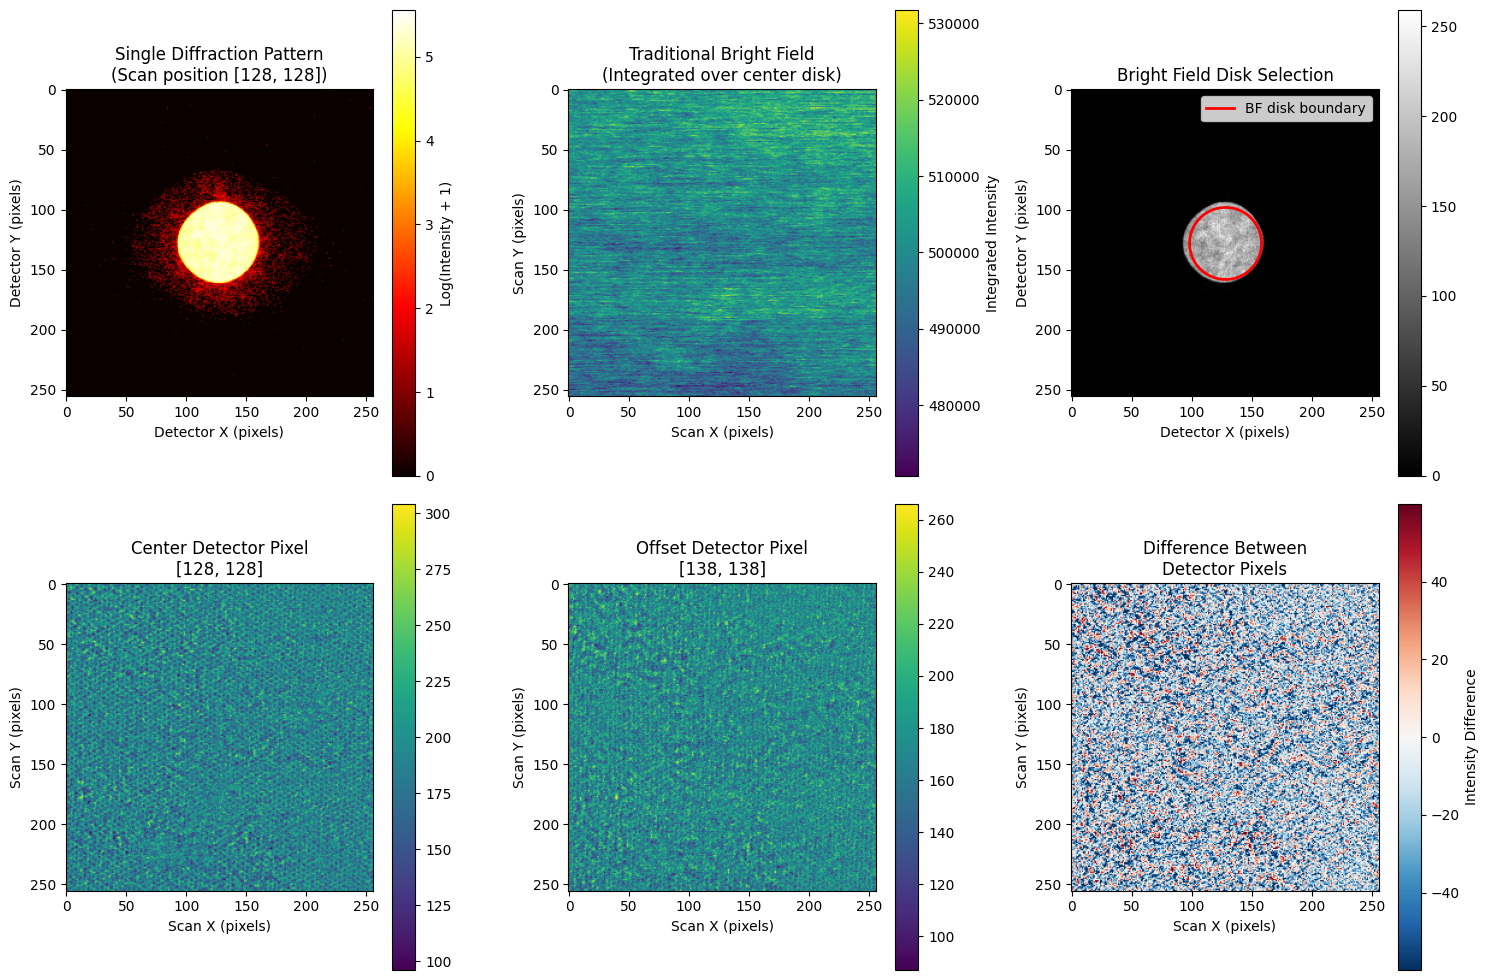


🔍 Key Observations:
  • Single diffraction pattern shows typical STEM pattern with bright center disk
  • Traditional BF integration gives 2821 detector pixels
  • Different detector pixels show DIFFERENT real-space images!
  • This difference is the key to super-resolution reconstruction


In [4]:
# Create a comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Single diffraction pattern from center of scan
center_scan_y, center_scan_x = big4d.shape[0] // 2, big4d.shape[1] // 2
diffraction_pattern = big4d[center_scan_y, center_scan_x, :, :]

im1 = axes[0, 0].imshow(np.log(diffraction_pattern + 1), cmap='hot')
axes[0, 0].set_title(f'Single Diffraction Pattern\n(Scan position [{center_scan_y}, {center_scan_x}])')
axes[0, 0].set_xlabel('Detector X (pixels)')
axes[0, 0].set_ylabel('Detector Y (pixels)')
plt.colorbar(im1, ax=axes[0, 0], label='Log(Intensity + 1)')

# 2. Traditional bright field (integrate center detector region)
detector_center_y, detector_center_x = big4d.shape[2] // 2, big4d.shape[3] // 2
bf_radius = 30  # Bright field disk radius

# Create circular mask for bright field
y_det, x_det = np.ogrid[:big4d.shape[2], :big4d.shape[3]]
bf_mask = (x_det - detector_center_x)**2 + (y_det - detector_center_y)**2 <= bf_radius**2

# Traditional bright field: sum over masked detector region
traditional_bf = np.sum(big4d[:, :] * bf_mask[None, None, :, :], axis=(2, 3))

im2 = axes[0, 1].imshow(traditional_bf)
axes[0, 1].set_title('Traditional Bright Field\n(Integrated over center disk)')
axes[0, 1].set_xlabel('Scan X (pixels)')
axes[0, 1].set_ylabel('Scan Y (pixels)')
plt.colorbar(im2, ax=axes[0, 1], label='Integrated Intensity')

# 3. Show the bright field mask
im3 = axes[0, 2].imshow(diffraction_pattern, cmap='gray')
# Overlay BF disk boundary
theta = np.linspace(0, 2*np.pi, 100)
circle_x = detector_center_x + bf_radius * np.cos(theta)
circle_y = detector_center_y + bf_radius * np.sin(theta)
axes[0, 2].plot(circle_x, circle_y, 'r-', linewidth=2, label='BF disk boundary')
axes[0, 2].set_title('Bright Field Disk Selection')
axes[0, 2].set_xlabel('Detector X (pixels)')
axes[0, 2].set_ylabel('Detector Y (pixels)')
axes[0, 2].legend()
plt.colorbar(im3, ax=axes[0, 2])

# 4. Individual detector pixel "images"
# Show what different detector pixels see across the scan
pixel1_image = big4d[:, :, detector_center_y, detector_center_x]  # Center pixel
pixel2_image = big4d[:, :, detector_center_y + 10, detector_center_x + 10]  # Offset pixel
pixel3_image = big4d[:, :, detector_center_y - 10, detector_center_x - 10]  # Different offset

im4 = axes[1, 0].imshow(pixel1_image)
axes[1, 0].set_title(f'Center Detector Pixel\n[{detector_center_y}, {detector_center_x}]')
axes[1, 0].set_xlabel('Scan X (pixels)')
axes[1, 0].set_ylabel('Scan Y (pixels)')
plt.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(pixel2_image)
axes[1, 1].set_title(f'Offset Detector Pixel\n[{detector_center_y + 10}, {detector_center_x + 10}]')
axes[1, 1].set_xlabel('Scan X (pixels)')
axes[1, 1].set_ylabel('Scan Y (pixels)')
plt.colorbar(im5, ax=axes[1, 1])

# 5. Difference between detector pixels
pixel_difference = pixel2_image.astype(np.float32) - pixel1_image.astype(np.float32)

im6 = axes[1, 2].imshow(pixel_difference, cmap='RdBu_r', 
                       vmin=-np.std(pixel_difference)*2, vmax=np.std(pixel_difference)*2)
axes[1, 2].set_title('Difference Between\nDetector Pixels')
axes[1, 2].set_xlabel('Scan X (pixels)')
axes[1, 2].set_ylabel('Scan Y (pixels)')
plt.colorbar(im6, ax=axes[1, 2], label='Intensity Difference')

plt.tight_layout()
plt.show()

print(f"\n🔍 Key Observations:")
print(f"  • Single diffraction pattern shows typical STEM pattern with bright center disk")
print(f"  • Traditional BF integration gives {bf_mask.sum()} detector pixels")
print(f"  • Different detector pixels show DIFFERENT real-space images!")
print(f"  • This difference is the key to super-resolution reconstruction")

## Step 4: Select the Bright Field Disk



Original shape: (256, 256, 256, 256)
Trimmed shape: (256, 256, 64, 64)


/tmp/ipykernel_1262847/2808518103.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(trim4d[0,0,:,:]))


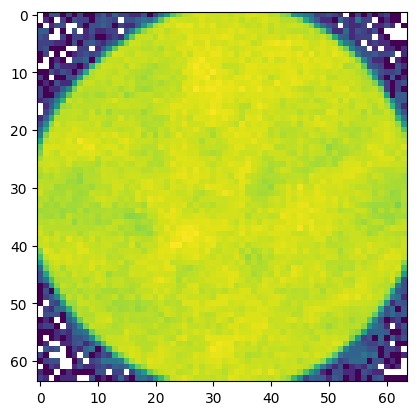

In [ ]:

center_u,center_v = 128,126
size_u, size_v = 64,64
trim4d = big4d[:,:,center_u-size_u//2:center_u+size_u//2,center_v-size_v//2:center_v+size_v//2]

print(f"Original shape: {big4d.shape}")
print(f"Trimmed shape: {trim4d.shape}")


plt.imshow(np.log(trim4d[0,0,:,:]))
plt.show()

In [14]:
FT4d = np.fft.fftn(trim4d,axes=(0,1))

/tmp/ipykernel_1262847/2900132257.py:3: RuntimeWarning: divide by zero encountered in log
  ax[1].imshow(np.log( (np.abs(FT4d[0,0,:,:]))))


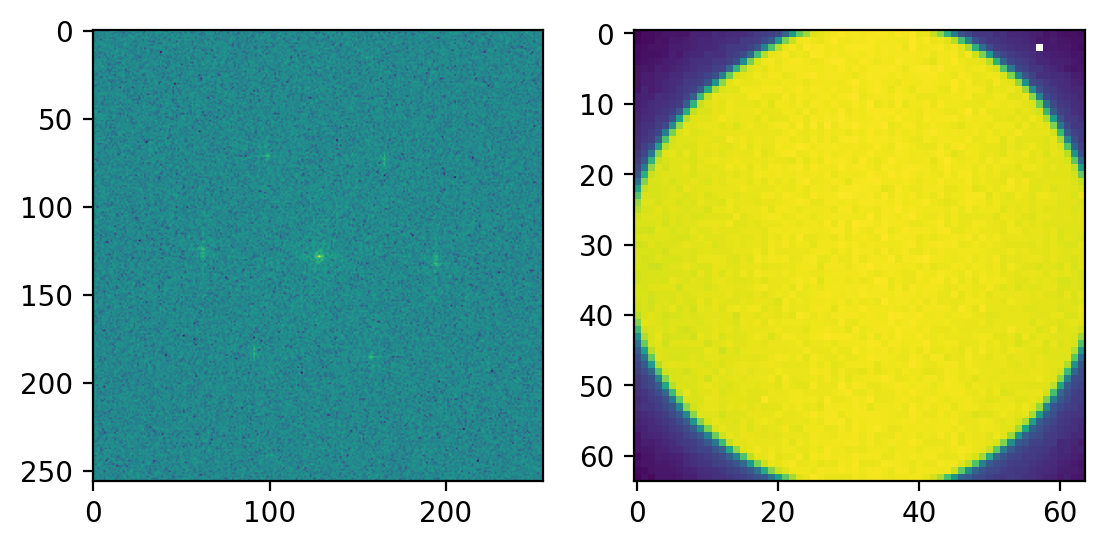

In [15]:
fig,ax = plt.subplots(1,2,dpi=200)
ax[0].imshow(np.log(np.fft.fftshift(np.abs(FT4d[:,:,0,0]))))
ax[1].imshow(np.log( (np.abs(FT4d[0,0,:,:]))))


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

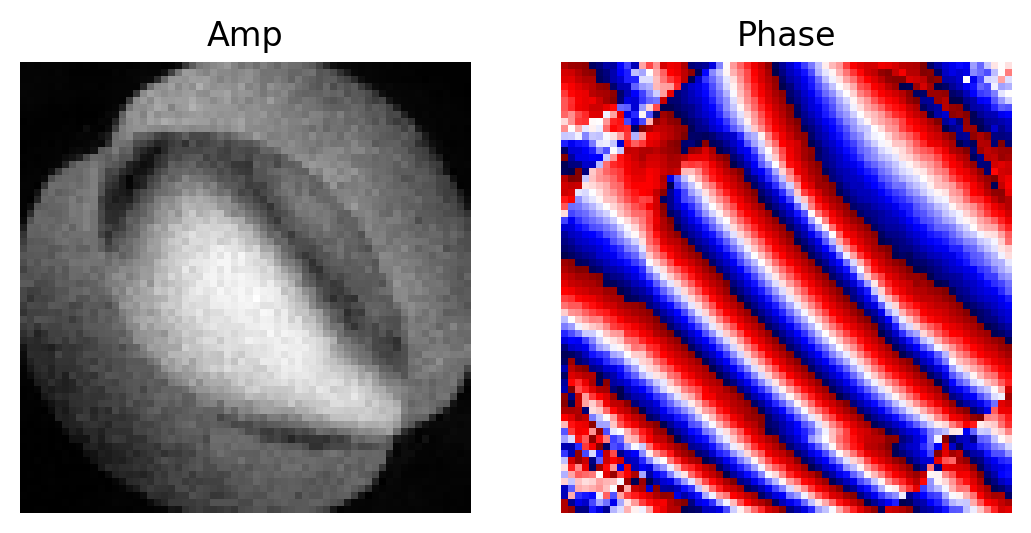

In [16]:
fig,ax = plt.subplots(1,2,dpi=200)
ax[0].imshow( ((np.abs(FT4d[5,66,:,:]))),cmap='Greys_r')
ax[0].set_title('Amp')
ax[0].axis('off')
ax[1].imshow( ((np.angle(FT4d[5,66,:,:]))),cmap='seismic')
ax[1].set_title('Phase')
ax[1].axis('off')